In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.io.shapereader import Reader
from cartopy.feature.nightshade import Nightshade
# 这些是其余要用到的库
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import datetime

In [2]:
import os
import numpy as np
import scipy.io as scio
usa_station_locations = scio.loadmat('D:\\HKG1\\revise2\\program\\autocorrelation_usa_locations.mat')
hkia_station_locations = scio.loadmat('D:\\HKG1\\revise2\\program\\autocorrelation_hkia_locations.mat')
import matplotlib.pyplot as plt
data = []
for i in range(usa_station_locations['lat_lon'].shape[0]):

    # folium.CircleMarker([usa_station_locations['lat_lon'][i][0],usa_station_locations['lat_lon'][i][1]],radius=2,color="#33a3dc",fill=True,fill_color='#33a3dc').add_to(m)
    if (usa_station_locations['ac_n_lag_2'][i][0] !=0)&(~np.isnan(usa_station_locations['ac_n_lag_2'][i][0])):
        data.append([usa_station_locations['lat_lon'][i][0],usa_station_locations['lat_lon'][i][1],usa_station_locations['ac_n_lag_2'][i][0]])

for i in range(hkia_station_locations['lat_lon'].shape[0]):

    # folium.CircleMarker([usa_station_locations['lat_lon'][i][0],usa_station_locations['lat_lon'][i][1]],radius=2,color="#33a3dc",fill=True,fill_color='#33a3dc').add_to(m)
    if (hkia_station_locations['ac_n_lag_2'][i][0] !=0)&(~np.isnan(hkia_station_locations['ac_n_lag_2'][i][0])):
        data.append([hkia_station_locations['lat_lon'][i][0],hkia_station_locations['lat_lon'][i][1],hkia_station_locations['ac_n_lag_2'][i][0]])
data = np.array(data)

In [3]:
from math import radians, cos, sin, asin, sqrt 

def haversine(lon1, lat1, lon2, lat2):
    # IDW插值方法
    R =  6372.8
    dLon = radians(lon2 - lon1)
    dLat = radians(lat2 - lat1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    d = R * c
    return d
def IDW(x, y, z, xi, yi):
    lstxyzi = []
    for p in range(len(xi)):
        lstdist = []
        for s in range(len(x)):
            d = (haversine(x[s], y[s], xi[p], yi[p]))
            lstdist.append(d)
        sumsup = list((1 / np.power(lstdist, 2)))
        suminf = np.sum(sumsup)
        sumsup = np.sum(np.array(sumsup) * np.array(z))
        u = sumsup / suminf
        xyzi = [xi[p], yi[p], u]

        lstxyzi.append(xyzi)
    return(lstxyzi)

def interp_data(extent,grid,lon,lat,known_data):
    Lon1 = extent[0]
    Lon2 = extent[1]
    Lat1 = extent[2]
    Lat2 = extent[3]
    grid_lon_list=np.linspace(Lon1,Lon2,grid)
    grid_lat_list=np.linspace(Lat1,Lat2,grid)
    # 转换成网格
    newlon, newlat = np.meshgrid(grid_lon_list, grid_lat_list)
    #数据扁平化
    grid_lon_list = newlon.flatten().tolist()
    grid_lat_list = newlat.flatten().tolist()
    sta_data=np.array(IDW(lon,lat,known_data,grid_lon_list,grid_lat_list))
    sta_lon=sta_data[:,0].reshape(grid,grid)
    sta_lat=sta_data[:,1].reshape(grid,grid)
    sta_idw=sta_data[:,2].reshape(grid,grid)
    return sta_lon,sta_lat,sta_idw

In [8]:
extent_usa = [-180, -40,0, 90]
grid_usa = 100
lon = (data[:,1]).tolist()
lat = data[:,0].tolist()
known_data = data[:,2]
sta_lon_usa,sta_lat_usa,sta_idw_usa = interp_data(extent_usa,grid_usa,lon,lat,known_data)

In [76]:
extent_hk = [113.8,114.0,22.25,22.4]
grid_hk = 10
lon = (data[:,1]).tolist()
lat = data[:,0].tolist()
known_data = data[:,2]
sta_lon_hkia,sta_lat_hkia,sta_idw_hkia = interp_data(extent_hk,grid_hk,lon,lat,known_data)

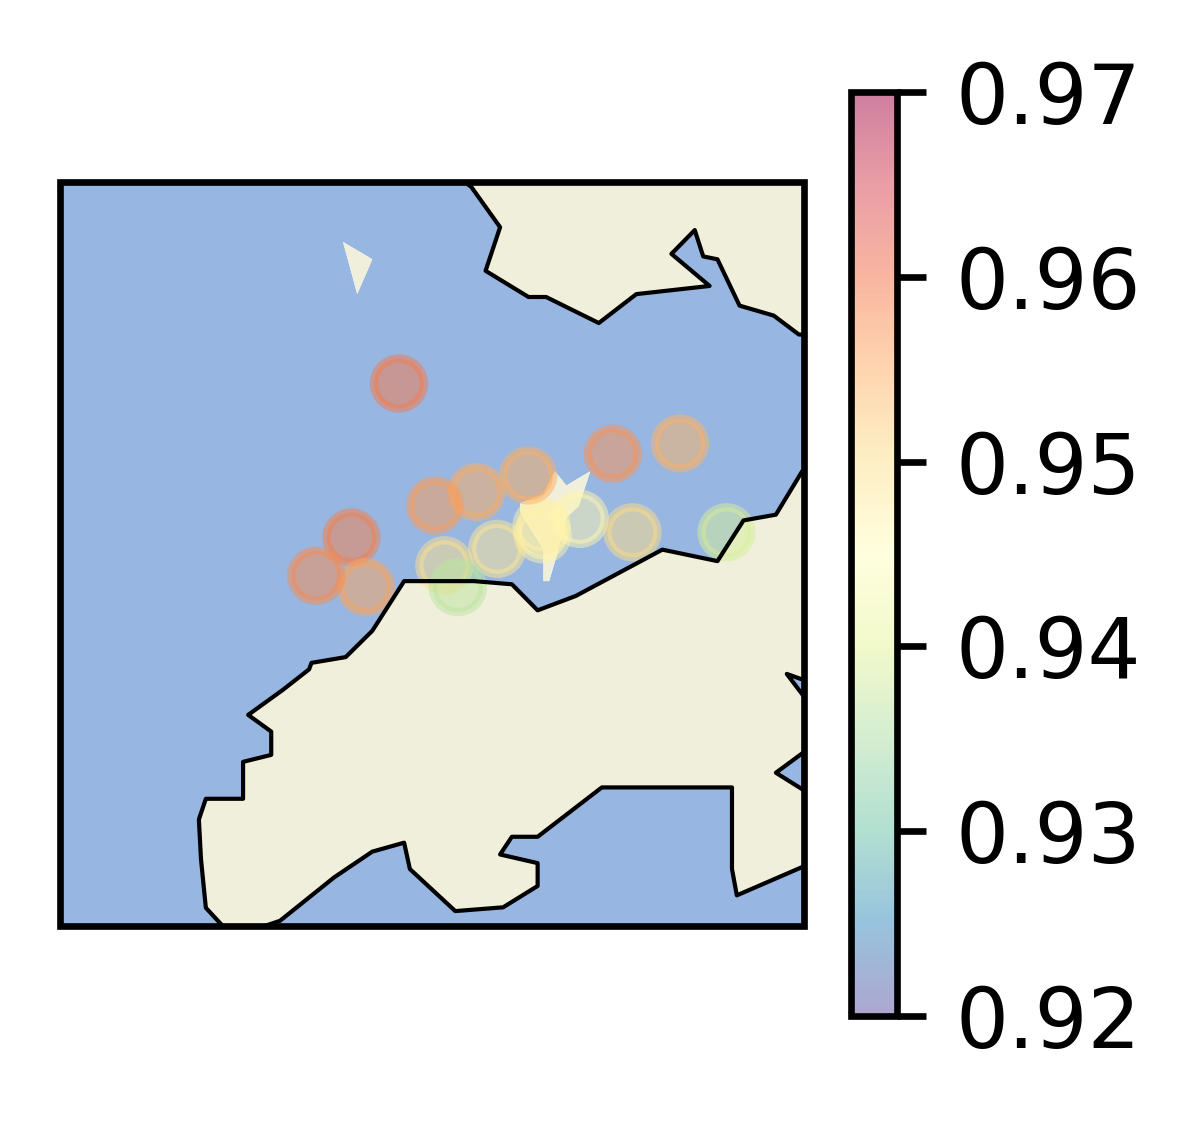

In [8]:

def plot_hkia_maxzoom(ax):
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=0.5)
    # ax.add_feature(cfeature.BORDERS.with_scale('10m'),lw=0.1)
    # ax.set_xticks([ 0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
    # ax.set_yticks([ -90,-60, -30, 0, 30, 60,90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(color = 'gray',direction='in')
    ax.set_extent([113.8,114.0,22.2,22.4],crs = ccrs.PlateCarree()) #[113.8,114.0,22.2,22.4]
    # # ax.gridlines(linestyle='--')

    levels = np.arange(0.92, 0.97, 0.001)
    cf = ax.scatter(data[:,1],data[:,0],
                c=data[:,2],cmap='Spectral_r',alpha=0.5)
    cbar = fig.colorbar(mappable=cf)
    cbar.mappable.set_clim([0.92,0.97])
    # cf = ax.contour(sta_lon_hkia,sta_lat_hkia, sta_idw_hkia,tranform=ccrs.PlateCarree(),alpha = 0.5)
    # cax = fig.add_axes([0.05, 0.06, 0.75, 0.01])
    # cbar = fig.colorbar(cf,ax=ax,orientation='horizontal',cax=cax)
    # cbar.ax.tick_params(which="major",direction="in",length=2,labelsize=10)#设置图例格式
    # cbar.set_label("单位：ug/m3",loc="right",fontdict = {'size':30})
    # plt.show(block=True)

    # lat = sta_lat_hkia[:,0]
    # lon = sta_lon_hkia[0,:]
    # df = pd.DataFrame(index=lat,columns=lon,data=sta_idw_hkia)
    # df.index.name = 'lat'
    # df.columns.name = 'lon'
    # hkia_da = xr.DataArray(df)
    # temp = hkia_da.isel()
    # shp_path = '.\\salem_relative_shp\\ne_10m_ocean_scale_rank\\ne_10m_ocean_scale_rank.shp'
    # t = temp.salem.roi(shape = shp_path)
    # t.plot.contourf(
    #     ax=ax,  
    #     levels=levels, 
    #     cmap='Spectral_r', 
    #     transform=ccrs.PlateCarree(), 
    #     extend='both'
    # )
%matplotlib inline
fig = plt.figure(figsize=(2, 2), dpi=600)  
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
plot_hkia_maxzoom(ax)
# plt.savefig('D:\\HKG1\\revise2\\figures\\hkia_ss_map.pdf')

In [10]:
import xarray as xr
import numpy as np
import pandas as pd
import salem

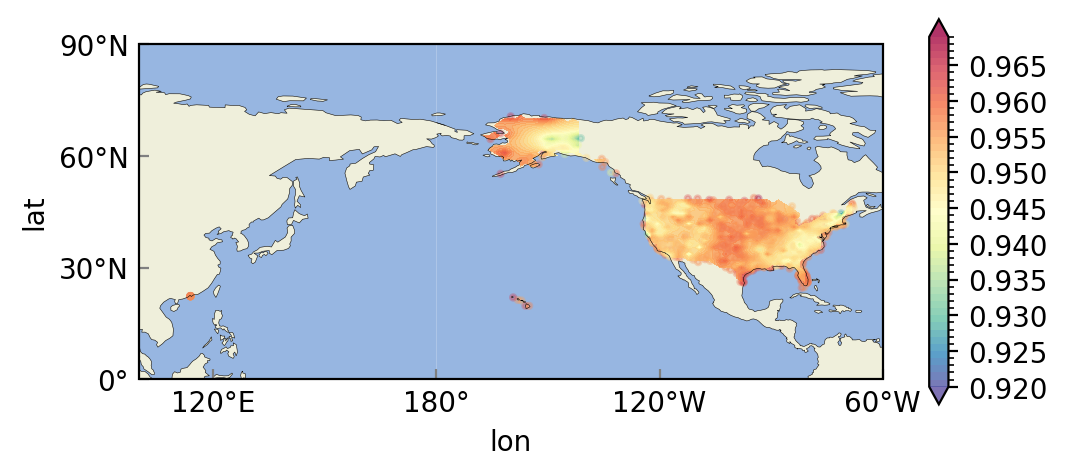

In [11]:
lat = sta_lat_usa[:,0]
lon = sta_lon_usa[0,:]
df = pd.DataFrame(index=lat,columns=lon,data=sta_idw_usa)
df.index.name = 'lat'
df.columns.name = 'lon'
usa_da = xr.DataArray(df
                      )
temp = usa_da.isel()
fig = plt.figure(figsize=(6, 2.5), dpi=200)  
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.OCEAN)#.with_scale('10m')
ax.add_feature(cfeature.LAND)#.with_scale('10m')
ax.add_feature(cfeature.COASTLINE,lw=0.2)#.with_scale('10m')
# ax.add_feature(cfeature.BORDERS,lw=0.1)
ax.set_xticks([ 0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([ -90,-60, -30, 0, 30, 60,90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(color = 'gray',direction='in')
ax.set_extent([100,300,0,90],crs = ccrs.PlateCarree()) 
ax.scatter(data[:,1]-180,data[:,0],
                c=data[:,2],cmap='Spectral_r',alpha=0.3,s=4)
shp_path = '.\\USA123\\USA_adm2.shp'
t = temp.salem.roi(shape = shp_path)
levels = np.arange(0.92, 0.97, 0.001)
t.plot.contourf(
    ax=ax, 
    cmap='Spectral_r', 
    levels = levels,
    transform=ccrs.PlateCarree(), 
    extend='both',alpha = 0.8
)
plt.savefig('D:\\HKG1\\revise2\\figures\\usa_ss_map.pdf')

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.io.shapereader import Reader
from cartopy.feature.nightshade import Nightshade
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import datetime

In [2]:
import os
import xarray as xr
import glob
import rasterio
dem_path = 'D:\\HKG1\\revise2\\plot_map\\QINGHUA\\DEM_DATA'
x_range = [20,25,30,35,40,45,50,55]
y_range = [70,75,80,85,90,95,100,105,110,115,120]
for i_y in range(len(y_range)):
    for i_x in range(len(x_range)):
        name = f'n{x_range[i_x]}e{y_range[i_y]}.tif'
        dem_file = os.path.join(dem_path,name)
        ds = xr.open_rasterio(dem_file)
        if (i_x==0):
            data_x = ds[0][::50,::50]
            y = ds['y'][::50]
        else:
            data_x = np.vstack((ds[0][::50,::50],data_x))
            y = np.hstack((ds['y'][::50],y))
    if (i_y==0)&(i_x == len(x_range)-1):
        data_xy = data_x
        x = ds['x'][::50]
    else:
        data_xy = np.hstack((data_xy,data_x))
        x = np.hstack((x,ds['x'][::50]))


In [3]:
import pandas as pd
lat = y
lon = x
df = pd.DataFrame(index=lat,columns=lon,data=data_xy)
df.index.name = 'lat'
df.columns.name = 'lon'
dem_da = xr.DataArray(df)

d:\anaconda\envs\map_new\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
d:\anaconda\envs\map_new\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
d:\anaconda\envs\map_new\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
d:\anaconda\envs\map_new\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


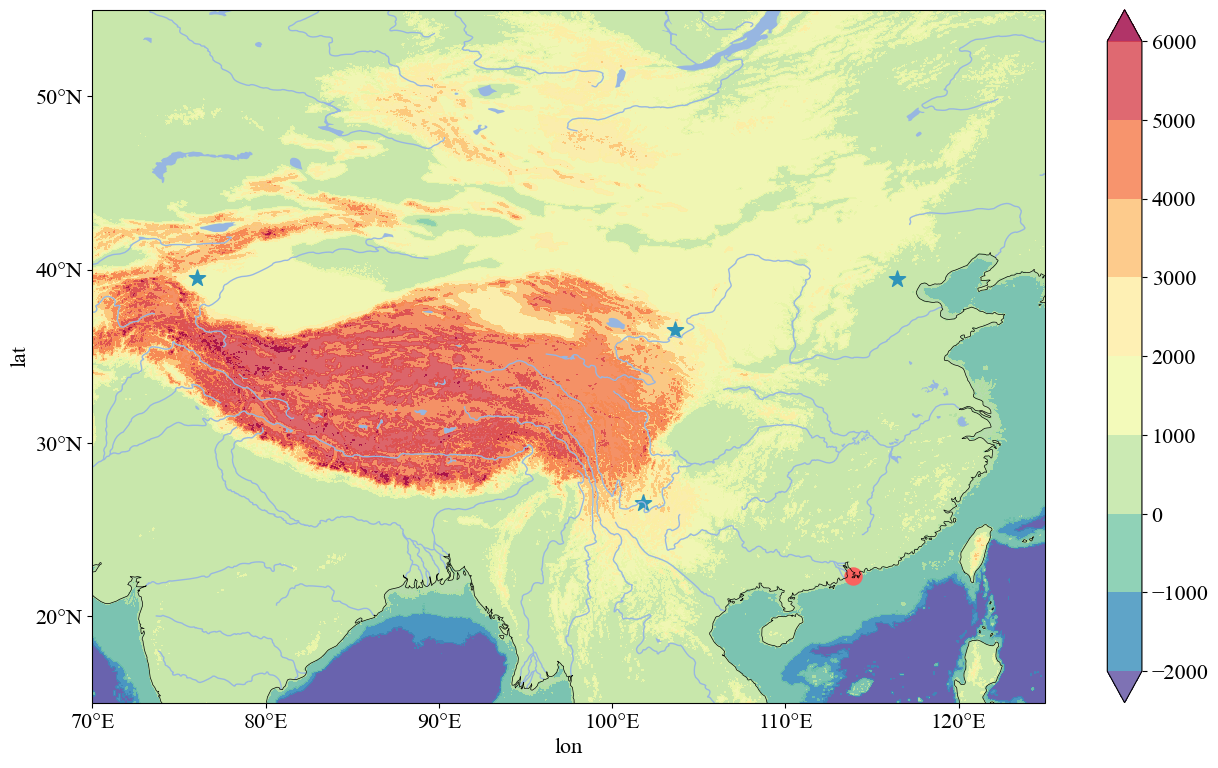

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.io.shapereader import Reader
# import maskout
# import rioxarray as rxr
import os
from matplotlib import rcParams
%matplotlib inline
config = {"font.family":'Times New Roman',"font.size": 16,"mathtext.fontset":'stix'}
rcParams.update(config)
fig = plt.figure(1, figsize=[16,9])
proj=ccrs.PlateCarree()
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
# extent = [70,140,15,55]
# ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'),linewidth=0.5,zorder=2,color='k')# 添加海岸线
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.RIVERS.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
# ax.add_feature(cfeature.BORDERS,lw=0.1)


temp = dem_da.isel()
levels = np.arange(-2000, 7000, 1000)
temp.plot.contourf(
        ax=ax, 
        cmap='Spectral_r', 
        transform=ccrs.PlateCarree(), 
        extend='both',alpha = 0.8,
        levels = levels
    )
airpots_locations = np.array([[36.518011, 103.621853],
[39.485495, 116.438084],
[26.537935, 101.799402],
[39.54154, 76.025111]])
ax.scatter(airpots_locations[:,1],airpots_locations[:,0],marker='*',s = 150, c = '#2E94B9')
ax.scatter(113.9141,22.29853, marker='o',s = 150, c = "#fa625f")

ax.set_xticks([ 70,80,90,100,110,120], crs=ccrs.PlateCarree())
ax.set_yticks([ 20,30,40,50], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
plt.savefig('D:\\HKG1\\revise2\\figures\\other_airports_china.pdf')
plt.show(block=True)

In [69]:
airpots_locations = np.array([[36.518011, 103.621853],
[39.861318, 98.338699],
[39.485495, 116.438084],
[26.537935, 101.799402],
[39.54154, 76.025111],  
[22.29853, 113.9141]   ])
airpots_locations.shape

(6, 2)

In [16]:
dem_file = 'D:\\BaiduNetdiskDownload\\cn_dem\\cn_dem.tif'
ds = rxr.open_rasterio(dem_file)
x = ds['x'][::500]
y = ds['y'][::500]
dem_data = ds[0][::500,::500]

MemoryError: Unable to allocate 66.9 GiB for an array with shape (1, 151200, 237600) and data type int16

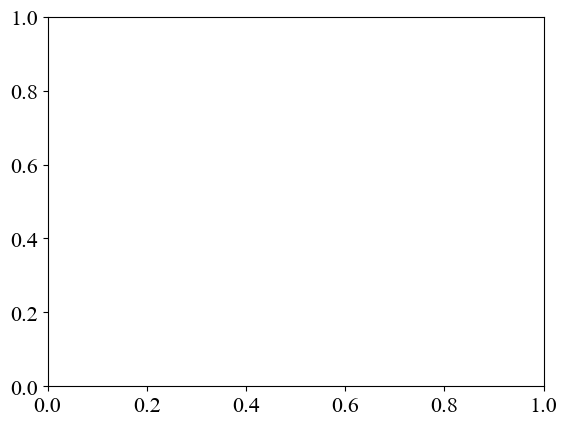

In [29]:
plt.plot(x)

In [51]:
dem_data.rename('x')

<xarray.DataArray 'x' (y: 303, x: 476)>
[144228 values with dtype=int16]
Coordinates:
    band         int32 1
  * x            (x) float64 73.0 73.14 73.28 73.42 ... 138.6 138.7 138.8 139.0
  * y            (y) float64 57.0 56.86 56.72 56.58 ... 15.47 15.33 15.19 15.06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [52]:
x.values

AttributeError: 'function' object has no attribute 'values'

In [36]:
import numpy as np
 
# 创建一个3x4的二维数组
arr = np.empty((303, 476))
arr = x.values
print(arr)

MemoryError: Unable to allocate 66.9 GiB for an array with shape (1, 151200, 237600) and data type int16

MemoryError: Unable to allocate 66.9 GiB for an array with shape (1, 151200, 237600) and data type int16

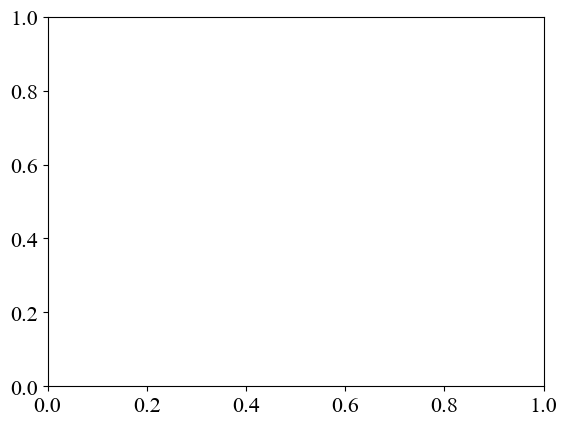

In [35]:
plt.plot(arr)